## Systèmes de décision
### Projet - optimisation d'un emploi du temps
#### Partie 1 : modélisation, implémentation avec Gurobi, résolution et affichage de la surface de Pareto

<i>Sommaire :</i>
<br>
<br>
[1 - Chargement des données](#sect1)
<br>
<br>
[2 - Définition des constantes](#sect2)
<br>
<br>
[3 - Instanciation du modèle et des variables](#sect3)
<br>
<br>
[4 - Définition des fonctions objectifs](#sect4)
<br>
<br>
[5 - Définition des contraintes](#sect5)
<br>
<br>
[6 - Optimisation et vérification du respect des contraintes](#sect6)
<br>
<br>
[7 - Calcul du "cube" de Pareto puis de la surface de Pareto](#sect7)
<br>
<br>
<br>

### 1 - Chargement des données
<a id="sect1"> </a>

In [11]:
import gurobipy as gp # solver
from gurobipy import GRB
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go # import pour l'affichage, si problème, possible de supprimer cet import
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [1]:
from InstanceClass import Instance # custom class built to load and encode instance files

In [29]:
instance = Instance(path="data/toy_instance.json")
instance.build_instance()

In [30]:
instance.variables # check that everything works as expected

{'NP': 5,
 'NC': 3,
 'NA': 3,
 'H': 5,
 'GAIN': [20, 15, 15, 20, 10],
 'PENALTIES': array([[0., 0., 0., 3., 6.],
        [0., 0., 0., 3., 6.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 3., 6.],
        [0., 0., 0., 0., 0.]]),
 'STAFF_QUALIFICATIONS': array([[1., 1., 1.],
        [1., 1., 0.],
        [0., 0., 1.]]),
 'COST_PROJECT': array([[1., 1., 1.],
        [1., 2., 0.],
        [1., 0., 2.],
        [0., 2., 1.],
        [0., 0., 2.]]),
 'CONGES': array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])}

Quelques précisions sur la convention de nommage (également détaillée dans le compte-rendu) : 
<br>
<br>
$n_p$ : le nombre de projets de l'instance
<br>
$n_c$ : le nombre de collaborateurs de l'instance
<br>
$n_a$ :  le nombre de compétences présentes dans l'instance
<br>
$h$ :  l'horizon de temps du problème (en jours), début au jour 1
<br>
<br>
<br>

### 2 - Définition des constantes
<a id="sect2"> </a>
Nous pouvons définir certaines constantes du problème directement à partir de l'encodage de l'instance visible ci-dessus. Par convention, les constantes sont nommées en majuscule.

In [31]:
GAIN = instance.variables["GAIN"]
PENALTIES = instance.variables["PENALTIES"]
# note : les lignes représentent les projets et les colonnes le temps en jours, les valeurs représentent ainsi la pénalité totale
COST_PROJECT = instance.variables["COST_PROJECT"] # cette variable représente le coût en compétences des projets
STAFF_QUALIFICATIONS = instance.variables["STAFF_QUALIFICATIONS"]
CONGES = instance.variables["CONGES"]
# bornes d'itération
I = instance.variables["NC"]
J = instance.variables["H"]
L = instance.variables["NP"]
K = instance.variables["NA"]

<br>
On aura donc :
<br>
<i>i</i> : indice de sommation sur les collaborateurs
<br>
<i>j</i> : indice de sommation sur le temps
<br>
<i>k</i> : indice de sommation sur les compétences
<br>
<i>l</i> : indice de sommation sur les projets
<br>
<br>
Certaines quantités constantes du problème se dérivent à partir des quantités précédentes.
<br>
<br>

In [6]:
BENEFICES = np.array(
    [
        GAIN[time_step] - PENALTIES[time_step] for time_step in range(L)
    ]
) # bénéfice net que pourrait donner le projet i s'il était rendu au temps j (matrice)

In [7]:
MAX_COST = np.max(COST_PROJECT) # coût maximal en compétence du projet i

In [8]:
print(
    "Les collaborateurs sont numérotés de 1 à {}".format(I)
)
print(
    "Les jours sont numérotés de 1 à {}".format(J)
)
print(
    "Les compétences sont numérotés de 1 à {}".format(K)
)
print(
    "Les projets sont numérotés de 1 à {}".format(L)
)

Les collaborateurs sont numérotés de 1 à 3
Les jours sont numérotés de 1 à 5
Les compétences sont numérotés de 1 à 3
Les projets sont numérotés de 1 à 5


In [9]:
times = np.arange(J) + 1

<br>
<br>

### 3 - Instanciation du modèle et des variables
<a id="sect3"> </a>

Nous allons maintenant définir un tenseur des affectations qui contiendra 4 dimensions. Le tenseur sera noté $A$.
<br>
<br>
L'élément de tenseur $a_{i, j, k, l}$ vaudra 1 si et seulement si le collaborateur <i>i</i> travail le jour <i>j</i> selon la compétence <i>k</i> le projet <i>l</i> (et vaudra 0 sinon).
<br>
<br>
Certaines fonctions de sommation sur ce tenseur nous serons ensuite utiles pour exprimer les fonctions objectifs et contraintes.
<br>
<br>

In [10]:
def calcul_work(Affectation):
    """
    Entrée(s) :
        Affectation (type) : tenseur des affectations des collaborateurs par compétence, sur les projets et dans le temps
        
    Sortie(s) :
        work (numpy.array) : matrice contenant le travail des collaborateurs dans le temps selon les compétences (en lignes) et les projets (en colonnes)
    """
    work = [
        np.sum([Affectation[i][j] for i in range(3)] , axis=0) for j in range(np.shape(Affectation)[1])
    ]
    return np.array(work)

In [11]:
def calcul_temporel_work(work):
    """
    Entrée(s) :
        work (numpy.array) : matrice contenant le travail total des collaborateurs dans le temps selon les compétences (en lignes) et les projets (en colonnes)
        
    Sortie(s) :
        work_over_time (numpy.array) : vecteur contenant le travail total des collaborateurs selon le temps et les compétences, par projets (en lignes)
    """
    work_over_time = [
        [gp.quicksum(work[0:i])[j] for i in range(1, J+1)] for j in range(L)
    ]
    return np.array(work_over_time)

In [12]:
def calcul_work_final(work):
    """
    Entrée(s) :
        work (type) : tenseur des affectations des collaborateurs par compétence, sur les projets et dans le temps
        
    Sortie(s) :
        work_per_project (numpy.array) : vecteur contenant le travail total des collaborateurs par projets (en lignes)
    """
    work_per_project = gp.quicksum(work)  
    return work_per_project

In [13]:
def compute_gain(Done_Project_solution):
    """
    Entrée(s) :
        Done_Project_solution (numpy.ndarray) : tenseur des affectations des collaborateurs par compétence, sur les projets et dans le temps
        
    Sortie(s) :
        gain (float) : vecteur des bénéfices nets relatifs à chaque projet (projets en lignes)
    """
    gain = 0
    for i in range(Done_Project_solution.shape[0]):
        gain += Done_Project_solution[i, :] @ BENEFICES[i, :]
    return gain

Nous pouvons désormais instancier le modèle et définir le tenseur $A$.
<br>
<br>
Note : la taille du tenseur $A$ est donc $n_c . h  . n_a. n_p$
<br>
<br>

In [14]:
model = gp.Model("model-part1")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


In [15]:
Affectation = model.addMVar(
    shape=(I,J,L,K),
    vtype=GRB.BINARY,
    name="Affectation"
)

Nous définissons ensuite une matrice $E$ qui contient les projets (en lignes) et les jours (en colonnes).
<br>
<br>
L'élément de matrice $e_{i, j}$ vaut 1 si et seulement si le projet <i>i</i> est terminé le jour <i>j</i> (c'est-à-dire que tous les apports de travail par compétences ont été validés au jour <i>j</i>). Pour tous les jours pour lesquels le projet <i>i</i> n'est pas encore terminé ou pas encore commencé, $e_{i, j}$ vaut 0. Pour tous les jours ultérieurs au jour de terminaison du projet <i>i</i> (si pertinent), $e_{i, j}$ vaut 0 également.
<br>
<br>

In [19]:
Done_Project = model.addMVar(
    shape=(L, J),
    vtype=GRB.BINARY,
    name="Done_Project"
)

On peut définir la matrice $S$ analogue à $E$ mais qui contient les jours de début des projets, selon la même logique.
<br>
<br>

In [18]:
Begin_Project = model.addMVar(
    shape=(L, J),
    vtype=GRB.BINARY,
    name="Begin_Project"
) 

<br>
<br>

### 4 - Définition des fonctions objectifs
<a id="sect4"> </a>

Pour simplifier la définition des fonctions objectifs (et anticiper le calcul prochain de la surface de Pareto du problème), on définit une fonction <i>set_objectives</i> qui va nous servir à intégrer, à volonté, certaines fonctions objectifs au problème.
<br>
<br>
<i>Remarque</i> : on souhaite à terme intégrer toutes les fonctions objectifs au problème, bien entendu !
<br>
<br>

In [20]:
def set_objectives(
    model,
    Done_Project,
    include_gain_obj: bool,
    include_nb_proj_obj: bool,
    include_proj_time_obj: bool
):
    """
        Entrée(s) :
            model,
            include_gain_obj (bool): True si on inclut l'optimisation du gain dans le problème,
            include_nb_proj_obj (bool): True si on inclut l'optimisation du nombre de projets max. du collab. le plus chargé dans le problème
            include_proj_time_obj (bool): True si on inclut l'optimisation du temps du projet le plus long dans le problème
        
        Sortie(s) :
         z_fo1, z_fo2, z_fo3: soit une variable Gurobi soit une constante réelle selon les choix faits en entrée
            
    """
    z_fo1 = gp.quicksum(gp.quicksum(Done_Project*BENEFICES))
    
    if include_gain_obj:
        model.setObjective(
            z_fo1,
            GRB.MAXIMIZE
        )
        
    if include_nb_proj_obj:
        z_fo2 = model.addVar(vtype=GRB.INTEGER, name="Max_Projet")
        model.setObjective(
            z_fo2,
            GRB.MINIMIZE
        )
    else:
        z_fo2 = 5 # default fixed value

    if include_proj_time_obj:
        z_fo3 = model.addVar(vtype=GRB.INTEGER, name="Duree_Max_Projet")
        model.setObjective(
           z_fo3,
           GRB.MINIMIZE
       )
    else:
        z_fo3 = 5 # default fixed value
        
    return z_fo1, z_fo2, z_fo3

In [21]:
def set_gain_objectives(
    model,
    Done_Project
):
    """
       Même principe que la fonction set_objectives précédente, mais ici seulement pour fixer l'optimisation du gain.
       Cette fonction sera utile lors de l'obtention de la surface de Pareto (FO2 et FO3 fixées).     
    """
    z_fo1 = gp.quicksum(gp.quicksum(Done_Project*BENEFICES))
    model.setObjective(z_fo1, GRB.MAXIMIZE)

    return z_fo1

In [22]:
z_fo1, z_fo2, z_fo3 = set_objectives(
    model, 
    Done_Project,
    True,
    False,
    False
)

<br>
<br>

### 5 - Définition des contraintes
<a id="sect5"> </a>

Avant de passer à la définition des contraintes du problème, nous allons instancier deux quantités annexes, les "travaux partiels", définis à partir des fonctions déclarées au début de la section <a>3 - Instanciation du modèle et des variables</a>.
<br>
<br>

In [23]:
final_work = calcul_work_final(calcul_work(Affectation)) # utile pour vérifier qu'un projet est terminé
# somme cumulée dans le temps du travail effectué par projet et par compétence
temp_work = calcul_temporel_work(calcul_work(Affectation))

<br>
<br>
On va d'abord définir les contraintes "de base" du problème.
<br>
<br>

In [24]:
def base_constraints(model, Affectation, temp_work, Begin_Project, Done_Project, z_fo1, z_fo2, z_fo3):
    """
    Implémentation des contraintes "de base" du problème (pas de notion d'objectif encore).
    """
    u = np.arange(J) + 1
    B0 = model.addConstrs(
        (Affectation[i,j,l,k] <= STAFF_QUALIFICATIONS[i,k] for i in range(I) for j in range(J) for l in range(L) for k in range(K)),
        name="Qualifications_Constraint"
    )
    B1 = model.addConstrs(
        (gp.quicksum(Affectation[i][j] @ np.transpose(np.array([1]*K))) <= 1-CONGES[i][j] for i in range(I) for j in range(J) for l in range(L)),
        name="Day_off_Constraint"
    ) 
    B2 = model.addConstrs(
        (temp_work[i][j] >= COST_PROJECT[i]*Done_Project[i][j] for i in range(L) for j in range(J)),
        name="Done"
    ) 
    B3 = model.addConstrs(
        (gp.quicksum(Done_Project[i]) <= 1 for i in range(L)),
        name="Only_Done_One_Time"
    ) 
    B4 = model.addConstrs(
        (gp.quicksum(Begin_Project[i])<= 1 for i in range(L)),
        name="Only_Begin_One_Time"
    ) 
    B5 = model.addConstrs(
        (gp.quicksum(Begin_Project[i]) == gp.quicksum(Done_Project[i]) for i in range(L)),
        name="Begin_Done"
    )
    B6 = model.addConstrs(
        (temp_work[i][j][k]/MAX_COST <= gp.quicksum(Begin_Project[i][0:(j+1)]) for i in range(L) for j in range(J) for k in range(K)),
        name="Cant_begin_without_work"
    ) 
    # number of projects done
    B7 = model.addConstr(
        (gp.quicksum(gp.quicksum(Done_Project)) <= z_fo2),
        name="Number_of_done_projects"
    )
    # time taken for the longest project (here, taken as a constraint for all projects)
    B8 = model.addConstrs(
        ((Done_Project[i]@times - Begin_Project[i]@times) <= z_fo3 for i in range(L)),
        name="Time_taken_for_projects"
    )


In [25]:
base_constraints(model, Affectation, temp_work, Begin_Project, Done_Project, z_fo1, z_fo2, z_fo3)

<br>
<br>
On va ensuite définir les contraintes additionnelles provenant de la linéarisation des fonctions objectifs initiales.
<br>
<br>

In [26]:
def fo2_constraints(model, Affectation, epsilon: float = 0.0001):
    """
    Implémentation des contraintes relatives à la fonction-objectif 2.
    """
    delta = model.addMVar(
        shape=(L, I),
        vtype=GRB.INTEGER,
        name="deltaFromC2")
    
    C21 = model.addConstrs(
        (gp.quicksum(delta)[i] <= z_fo2 for i in range(I)),
        name="C2.1"
    ) 
    C22 = model.addConstrs(
        ((J*(1-delta[l][i]))<=gp.quicksum(gp.quicksum(Affectation[i])[l]) for i in range(I) for l in range(L)),
        name="C2.2"
    )
    C23 = model.addConstrs(
        (gp.quicksum(gp.quicksum(Affectation[i])[l])+epsilon<=(J*delta[l][i]) for i in range(I) for l in range(L)),
        name="C2.3"
    )

In [27]:
# fo2_constraints(model, Affectation) # nous allons travailler à z_fo2 constant (pas d'optimisation)

In [28]:
def fo3_constraints(model, Done_Project, Begin_Project):
    """
    Implémentation des contraintes relatives à la fonction-objectif 3.
    """
    C31 = model.addConstrs(
        (gp.quicksum((Done_Project[i]-Begin_Project[i])*times)+1 <= z_fo3 for i in range(L)),
        name="Duration"
    ) 

In [29]:
# fo3_constraints(model, Done_Project, Begin_Project) # nous allons travailler à z_fo3 constant (pas d'optimisation)

### 6 - Optimisation et vérification du respect des contraintes
<a id="sect6"> </a>

In [30]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i3-6006U CPU @ 2.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 471 rows, 325 columns and 3150 nonzeros
Model fingerprint: 0x73d66cab
Variable types: 0 continuous, 325 integer (325 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+00]
  Objective range  [9e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 395 rows and 209 columns
Presolve time: 0.02s
Presolved: 76 rows, 116 columns, 518 nonzeros
Variable types: 0 continuous, 116 integer (116 binary)

Root relaxation: objective 8.000000e+01, 44 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   80.0000

#### Vérification des contraintes

In [60]:
if model.Status == GRB.OPTIMAL:
    Affectation_solution = Affectation.X
    Done_Project_solution = Done_Project.X
    Begin_Project_solution = Begin_Project.X
    NB_Project_solution = np.max(np.sum(np.sum(np.sum(Affectation_solution, axis=1), axis=2), axis=1)) # z_fo2
    Duration_solution = 1 + np.max([(Done_Project_solution[i]@times - Begin_Project_solution[i]@times) for i in range(J)]) # z_fo3

In [61]:
print("Le collaborateur qui a travaillé sur le plus de projets a travaillé sur {} projets différents.".format(NB_Project_solution))

Le collaborateur qui a travaillé sur le plus de projets a travaillé sur 4.0 projets différents.


In [62]:
print("Le projet qui a duré le plus de temps a duré {} jours.".format(Duration_solution))

Le projet qui a duré le plus de temps a duré 5.0 jours.


In [50]:
cumul_work = np.cumsum(np.sum(Affectation_solution,axis=0),axis=0)

In [51]:
# Qualifications
for i in range(I):
    for j in range(J):
        for l in range(L):
            for k in range(K):
                assert Affectation_solution[i,j,l,k] <= STAFF_QUALIFICATIONS[i,k] 

In [52]:
# One day One work
for i in range(I):
    for j in range(J):
        assert np.sum(Affectation_solution[i][j])<= 1- CONGES[i][j]

In [53]:
# Project Done one time
assert (np.sum(Done_Project_solution,axis=1)<=1).all()

In [54]:
# Assert Project done
for l in range(L):
    if np.sum(Done_Project_solution[l])==1:
        assert(
                (cumul_work[
                    np.where(Done_Project_solution[l] == 1)[0][0]
                ][l] >= COST_PROJECT[l]).all()
            )

In [55]:
# Project Done & Begin
assert((
np.sum(Done_Project_solution,axis=1)==np.sum(Begin_Project_solution,axis=1)
).all())

In [56]:
# Project are begin before
assert((
Done_Project_solution<=np.cumsum(Begin_Project_solution,axis=1)
).all())

In [63]:
# Assert Duration Project
for l in range(L):
    if np.sum(Done_Project_solution[l]) == 1: # si le projet a été choisi
        assert(
            (np.where(Done_Project_solution[l] == 1)[0][0] - np.where(Begin_Project_solution[l] == 1)[0][0]) +1 <= Duration_solution
            )

In [58]:
# Assert Nb project worked
for i in range(i):
    assert np.sum(np.sum(np.sum(Affectation_solution,axis=1)[i],axis=1)>=1)<=NB_Project_solution

In [59]:
# Working imply Beginned
for l in range(L):
    if np.sum(Done_Project_solution[l])==1:
        assert np.where(np.sum(cumul_work,axis=2).transpose()[l]>=1)[0][0] >= np.where(Begin_Project_solution[l]>=1)[0][0]

It's all good! Maintenant, nous allons répéter l'opération précédente (construction du modèle puis optimisation) pour avoir la surface de Pareto.

<br>

### 7 - Calcul du "cube" de Pareto puis de la surface de Pareto
<a id="sect7"> </a>

Chargement des résultats de l'optimisation.
<br>

In [64]:
instance.load_solution(model, Affectation, Done_Project, Begin_Project, z_fo2, z_fo3)
instance.save_solution(path="toy_instance/")
instance.print_kpi()

AttributeError: 'int' object has no attribute 'X'

#### Cube de Pareto pour le jeu "Toy"
<br>
On va chercher à optimiser la fonction-objectif "Gain" sur le jeu "Toy".

Une optimisation libre selon FO2 et FO3 donne un gain optimal de 65 unités. Normalisé, ce gain optimal vaut donc :
<br>
<br>
$1 - 65/80 = 0.1875$
<br>
<br>
Attention ! On a ici calculé :
<br>
<br>
$1 - val_{opt}$(FO1)
<br>
<br>
Une valeur de 0 voudrait dire que 100% des gains possibles ont été obtenus, pénalités déduites.
<br>
Pour ce gain optimal, le nombre de projets abordés par le collaborateur affecté sur le plus grand nombre de projets est 3, soit une valeur normalisée de :
<br>
<br>
$3/5 = 0.60$
<br>
<br>
Une valeur de 0 voudrait dire que le collaborateur le plus occupé a participé à tous les projets.
<br>
<br>
Enfin, pour ce gain optimal, le temps pris par le projet qui a pris le plus de temps est 3, soit une valeur normalisée de 0.60 également.
<br>
Une valeur de 0 voudrait dire que le projet ayant duré le plus longtemps a duré $h$ jours.
<br>
<br>

#### Résultat de l'optimisation de la fonction objectif 1 (gain total) sur le jeu "Medium"


On procède de la même manière sur le jeu "Medium". On trouve un gain optimal de :
<br>
<br>
$1 - 176/510 = 0.655$
<br>
<br>
Et des valeurs correspondent pour FO2 et FO3 à respectivement :
<br>
<br>
FO2 $= 6/15 = 0.40$
<br>
<br>
FO3 $= 9/22 = 0.41$

#### Résultat de l'optimisation de la fonction objectif 1 (gain total) sur le jeu "Large"


Enfin, le triplet pour le jeu "Large" est le suivant : $(253/1020 = 0.25, 8/25 = 0.32, 12/36 = 0.33)$.

#### Affichage du cube de Pareto pour le jeu "Toy"


Nous allons désormais afficher le cube de Pareto pour l'instance "Toy", mais on pourrait procéder de même pour les deux autres instances.
<br>
Selon l'axe 1 (FO1), l'optimal est trouvé pour une valeur de $0.1875$ et correspond au couple (FO2, FO3) = $(0.60, 0.60)$.
<br>
Selon l'axe 2 (FO2), l'optimal est trouvé pour une valeur de $0$ et correspond au couple (FO1, FO3) = $(1, 0)$. Pas du tout de travail (trivial).
<br>
Selon l'axe 3 (FO3), l'optimal est trouvé pour une valeur de $0$ et correspond au couple (FO1, FO2) = $(1, 0)$. Pas du tout de travail (trivial).
<br>
Nous en concluons que les coordonnées de la grande diagonale du cube de Pareto sont :

In [65]:
p1 = (
    1.0,
    0.6,
    0.6
)
p2 = (
    0.1875,
    0.0,
    0.0
)

In [66]:
fig = go.Figure(data=[
    go.Mesh3d(
        # 8 vertices of a cube
        x=[p1[0], p1[0], p2[0], p2[0], p1[0], p1[0], p2[0], p2[0]],
        y=[p1[1], p2[1], p2[1], p1[1], p1[1], p2[1], p2[1], p1[1]],
        z=[p1[2], p1[2], p1[2], p1[2], p2[2], p2[2], p2[2], p2[2]],

        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
        name='y',
        opacity=0.50
    )
])
fig.update_layout(
    scene = dict(
                xaxis = dict(nticks=10, range=[0,1],),
                yaxis = dict(nticks=10, range=[0,1],),
                zaxis = dict(nticks=10, range=[0,1],),
                xaxis_title='1 - Gain',
                yaxis_title='# projets du collab. le + occupé',
                zaxis_title='Durée du projet le plus long',
    ),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
fig.update_layout(title_text="Cube de Pareto (axes normalisés sur [0, 1])")
fig.show()

### Obtention de la surface de Pareto

Il nous faut maintenant la surface de Pareto. Elle est incluse dans le cube de Pareto affiché ci-dessus. Pour échantillonner la surface de Pareto, nous allons procéder par la méthode $\epsilon$-constraint vue en cours. Elle va nous permettre d'explorer la surface de Pareto en identifiant itérativement les points qui s'y trouvent.

Pour obtenir la surface de Pareto, on va travailler à $z_{fo_2}$ et $z_{fo_3}$ fixés puis chercher à optimiser le gain. En modifiant itérativement les bornes respectives de $z_{fo_2}$ et $z_{fo_3}$, nous allons obtenir les points de la surface de Pareto du problème. Cette surface est en deux dimensions car notre problème contient en tout 3 fonctions-objectif.
<br>
<br>

In [67]:
def build_model(z_fo2, z_fo3):
    """
    Construire le modèle d'optimisation du gain à z_fo2 et z_fo3 fixées (et dont les valeurs sont passées en argument).
    """
    model = gp.Model("model")
    model.setParam('OutputFlag', 0) # pas de sortie

    # définition des variables
    Affectation = model.addMVar(
        shape=(I,J,L,K),
        vtype=GRB.BINARY,
        name="Affectation"
    )
    Begin_Project = model.addMVar(
        shape=(L, J),
        vtype=GRB.BINARY,
        name="Begin_Project"
    )
    Done_Project = model.addMVar(
        shape=(L, J),
        vtype=GRB.BINARY,
        name="Done_Project"
    )

    # définition de la fonction-objectif (unique ici)
    z_fo1 = set_gain_objectives(
        model, 
        Done_Project
    )

    # définition des variables secondaires (elles dépendent des variables définies précédemment)
    final_work = calcul_work_final(calcul_work(Affectation))
    temp_work = calcul_temporel_work(calcul_work(Affectation))

    # définition des contraintes
    base_constraints(model, Affectation, temp_work, Begin_Project, Done_Project, z_fo1, z_fo2, z_fo3)
    # note importante : les contraintes relatives aux fonctions-objectif 2 et 3 ne sont pas incluses ici car seul l'objectif 1 prévaut
    # fo2_constraints(model, Affectation)
    # fo3_constraints(model, Done_Project, Begin_Project)
    
    return model, Affectation, temp_work, Begin_Project, Done_Project, z_fo1

In [70]:
ranges_fo3 = [J - k for k in range(0, J, 1)] # STEP à modifier pour mettre plus de points d'échantillonage si besoin
ranges_fo2 = [L - k for k in range(0, L, 1)]

In [71]:
ranges_fo3, ranges_fo2

([5, 4, 3, 2, 1], [5, 4, 3, 2, 1])

In [72]:
PARETO_POINTS = {}
for z_fo3 in ranges_fo3:
    PARETO_POINTS[z_fo3] = []
    for z_fo2 in tqdm(ranges_fo3):
        model, Affectation, temp_work, Begin_Project, Done_Project, z_fo1 = build_model(z_fo2, z_fo3)
        print("Solving the problem for z_fo2 = {}, z_fo3 = {}".format(z_fo2, z_fo3))
        model.optimize()
        Done_Project_solution = Done_Project.X
        gain = compute_gain(Done_Project_solution)
        PARETO_POINTS[z_fo3].append([gain, z_fo2])

  0%|          | 0/5 [00:00<?, ?it/s]

Solving the problem for z_fo2 = 5, z_fo3 = 5


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

Solving the problem for z_fo2 = 4, z_fo3 = 5


 60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Solving the problem for z_fo2 = 3, z_fo3 = 5


 80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Solving the problem for z_fo2 = 2, z_fo3 = 5


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Solving the problem for z_fo2 = 1, z_fo3 = 5


  0%|          | 0/5 [00:00<?, ?it/s]

Solving the problem for z_fo2 = 5, z_fo3 = 4


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]

Solving the problem for z_fo2 = 4, z_fo3 = 4


 60%|██████    | 3/5 [00:02<00:01,  1.40it/s]

Solving the problem for z_fo2 = 3, z_fo3 = 4


 80%|████████  | 4/5 [00:02<00:00,  1.44it/s]

Solving the problem for z_fo2 = 2, z_fo3 = 4


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Solving the problem for z_fo2 = 1, z_fo3 = 4


  0%|          | 0/5 [00:00<?, ?it/s]

Solving the problem for z_fo2 = 5, z_fo3 = 3


 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Solving the problem for z_fo2 = 4, z_fo3 = 3


 60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Solving the problem for z_fo2 = 3, z_fo3 = 3


 80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Solving the problem for z_fo2 = 2, z_fo3 = 3


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Solving the problem for z_fo2 = 1, z_fo3 = 3


  0%|          | 0/5 [00:00<?, ?it/s]

Solving the problem for z_fo2 = 5, z_fo3 = 2


 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

Solving the problem for z_fo2 = 4, z_fo3 = 2


 60%|██████    | 3/5 [00:01<00:01,  1.67it/s]

Solving the problem for z_fo2 = 3, z_fo3 = 2


 80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

Solving the problem for z_fo2 = 2, z_fo3 = 2


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Solving the problem for z_fo2 = 1, z_fo3 = 2


  0%|          | 0/5 [00:00<?, ?it/s]

Solving the problem for z_fo2 = 5, z_fo3 = 1


 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Solving the problem for z_fo2 = 4, z_fo3 = 1


 60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Solving the problem for z_fo2 = 3, z_fo3 = 1


 80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Solving the problem for z_fo2 = 2, z_fo3 = 1


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

Solving the problem for z_fo2 = 1, z_fo3 = 1


In [73]:
# FOR TOY PROBLEM
PARETO_POINTS

{5: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 4: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 3: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 2: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 1: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]]}

In [ ]:
# FOR MEDIUM PROBLEM
PARETO_POINTS

In [ ]:
# FOR LARGE PROBLEM
PARETO_POINTS

In [2]:
PARETO_POINTS = {5: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 4: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 3: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 2: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]],
 1: [[65.0, 5], [65.0, 4], [55.0, 3], [40.0, 2], [20.0, 1]]} # result obtained for the Toy instance

In [41]:
def plot_pareto_surface(PARETO_POINTS):
    fig = plt.figure(figsize=(8, 8))

    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')
    points = []
    for key in PARETO_POINTS.keys():
        for item in PARETO_POINTS[key]:
            points.append([item[0], item[1], key])
    
    X = np.array([1 - point[0]/np.sum(GAIN) for point in points])
    Y = np.array([point[1]/L for point in points])
    Z = np.array([point[2]/J for point in points])
    # plotting
    ax.scatter(
        X,
        Y,
        Z,
        'green'
        )
    ax.set_title('Pareto Surface for the Toy instance')
    plt.show()

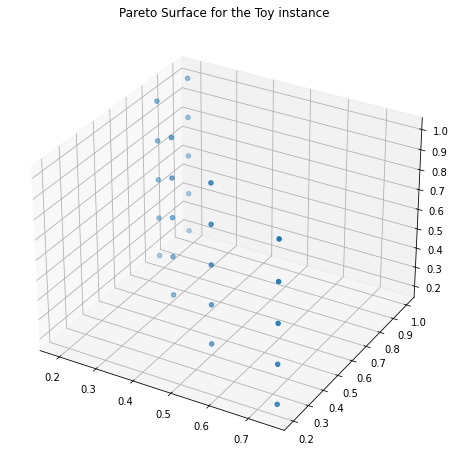

In [44]:
# draw the surface
%matplotlib inline
plot_pareto_surface(PARETO_POINTS)